# Optimizing a Simple Image Processing Pipeline

This notebook demonstrates how to use the `pipeoptz` library to optimize the parameters of a simple image processing pipeline.

The goal is to take a noisy and blurry image of a circle and find the best parameters for a Gaussian blur and a thresholding operation to make the result as close as possible to a reference image.

We will explore several optimization algorithms provided by the library:
- Ant Colony Optimization (ACO)
- Simulated Annealing (SA)
- Particle Swarm Optimization (PSO)
- Genetic Algorithm (GA)
- Bayesian Optimization (BO)
- Grid Search (GS)

## 1. Imports

First, we import the necessary libraries.
- `cv2` (OpenCV) for basic image processing functions.
- `numpy` for numerical operations.
- `matplotlib.pyplot` and `PIL` for displaying images.
- The components from `pipeoptz`: `Pipeline`, `Node`, `PipelineOptimizer`, parameter types, and the `mse_loss` cost function.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys, os
from pipeoptz import Pipeline, Node, PipelineOptimizer, FloatParameter, IntParameter

## 2. Pipeline Node Functions

Here, we define the Python functions that will serve as nodes in our pipeline. Each function takes an image and parameters as input, and returns a processed image.

- `gaussian_blur`: Applies a Gaussian blur. Note that the kernel size `k` is converted to an odd integer inside the function.
- `threshold`: Applies a binary threshold to the image.

In [2]:
def gaussian_blur(image, k, sigma):
    # The kernel size need to be an odd  integer
    k = int(k)*2+1
    return cv2.GaussianBlur(image, (k, k), sigmaX=sigma)

def threshold(image, threshold_value):
    im = image.copy()
    im[cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)[1]==0] = 0
    return im

## 3. Data Generation

To test and optimize our pipeline, we need a dataset.
The `generate_data` function creates:
- An input image `X`: A gray circle that has been significantly blurred and has had random noise added to it.
- A target image (ground truth) `y`: The original, sharp gray circle.

The optimizer's goal will be to find the pipeline parameters that transform `X` into an image as close as possible to `y`.

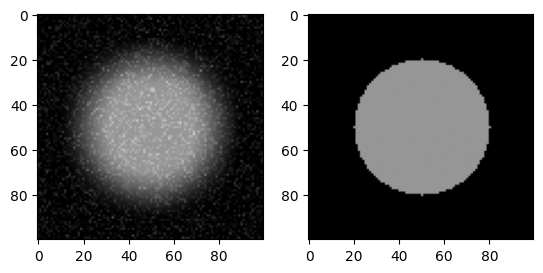

In [3]:
def generate_data():
    # Input image : a blured & noised circle
    X = np.zeros((100, 100), dtype=np.uint8)
    cv2.circle(X, (50, 50), 30, 150, -1)
    y = np.zeros((100, 100), dtype=np.uint8)
    cv2.circle(y, (50, 50), 30, 150, -1)

    X = cv2.GaussianBlur(X, (21, 21), 10)
    noise = np.zeros(X.shape, np.uint8)
    cv2.randn(noise, 0, 20)
    X = cv2.add(X, noise)

    return X, y

X, y = generate_data()
plt.subplot(121)
plt.imshow(X, cmap="gray", vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(y, cmap="gray", vmin=0, vmax=255)

We generate a small batch of `X` (input) and `y` (target) images. Using a batch rather than a single image helps the optimizer find more robust parameters.

In [4]:
length = 4
X = []
y = []
for _ in range(length):
    Xi, yi = generate_data()
    X.append({"image":Xi})
    y.append(yi)

## 4. Building the Pipeline

Now, we define the structure of our pipeline using the `Pipeline` and `Node` classes.
- We create an instance of `Pipeline`.
- We add two nodes:
    1. A `blur` node that uses the `gaussian_blur` function.
    2. A `threshold` node that uses the `threshold` function.
- We define the data flow with the `predecessors` argument.
    - The `blur` node takes its `image` input from the pipeline's runtime parameters (`run_params:image`).
    - The `threshold` node takes its `image` input from the output of the `blur` node.

Finally, we visualize the pipeline structure as a graph.

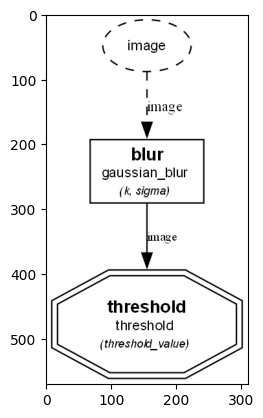

In [5]:
pipeline = Pipeline(name="opti_img")
pipeline.add_node(Node(id="blur", func=gaussian_blur, fixed_params={'k': 5, 'sigma': 1.0}), predecessors={'image': 'run_params:image'})
pipeline.add_node(Node(id="threshold", func=threshold, fixed_params={'threshold_value': 127}), predecessors={'image': 'blur'})

pipeline.to_dot("opti_img.dot")
pipeline.to_image("opti_img.png")
plt.imshow(Image.open("opti_img.png"))

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def pipeline_interactive(sigma, k, threshold):
    pipeline.set_fixed_params({"blur.sigma":sigma, "blur.k":k, "threshold.threshold_value":threshold})
    plt.figure(figsize=(length*2.5,3*2.5))
    plt.subplot(1,length+1,1)
    plt.title("Goal")
    plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)
    for i in range(length):
        index, hist, _ = pipeline.run(X[i])
        plt.subplot(1,length+1,i+2)
        plt.imshow(hist[index], cmap="gray", vmin=0, vmax=255)
{'blur.sigma': 7.555938753213502, 'blur.k': 7, 'threshold.threshold_value': 76}

interact(pipeline_interactive, sigma=(0., 20.), k=(0,10), threshold=(0,128))


interactive(children=(FloatSlider(value=10.0, description='sigma', max=20.0), IntSlider(value=5, description='…

<function __main__.pipeline_interactive(sigma, k, threshold)>

## 5. Optimizer Setup

With the pipeline defined, we configure the `PipelineOptimizer`.
- It takes our `pipeline`, a `loss_function` (`mse_loss` in this case, which calculates the mean squared error between the pipeline's output and the target `y`), and optional constraints like `max_time_pipeline`.
- We then define the search space for the parameters we want to optimize using `add_param`. We specify the node, the parameter name, and its value range (`min_value`, `max_value`).

In [7]:
def mse_loss(im1, im2):
    return np.mean((im1.astype(np.float32)-im2.astype(np.float32))**2)

In [8]:
optimizer = PipelineOptimizer(
        pipeline=pipeline,
        loss_function=mse_loss,
        max_time_pipeline=0.01
    )

optimizer.add_param(FloatParameter(node_id='blur', param_name='sigma', min_value=0.1, max_value=20.0))
optimizer.add_param(IntParameter(node_id='blur', param_name='k', min_value=1, max_value=10))
optimizer.add_param(IntParameter(node_id='threshold', param_name='threshold_value', min_value=1, max_value=254))

## 6. Running the Optimizations

We will now run the optimizer with different metaheuristic algorithms. For each one, we will display:
1. The evolution of the cost function (loss) over the iterations.
2. The best image result produced by the pipeline with the optimized parameters.
3. The target image for comparison.

### Ant Colony Optimization (ACO)

{'blur.sigma': np.float64(4.032102239324092), 'blur.k': np.int64(3), 'threshold.threshold_value': np.int64(74)}


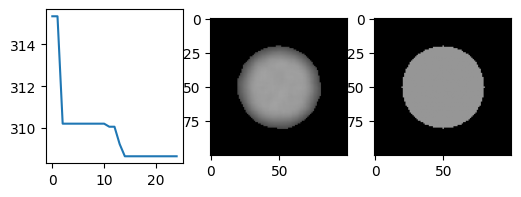

In [9]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="ACO", 
        iterations=25,
        ants=10,
        verbose=True
)

print(best_params)
pipeline.set_fixed_params(best_params)
i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

### Simulated Annealing (SA)

{'blur.sigma': 3.1236820778671475, 'blur.k': 3, 'threshold.threshold_value': 75}


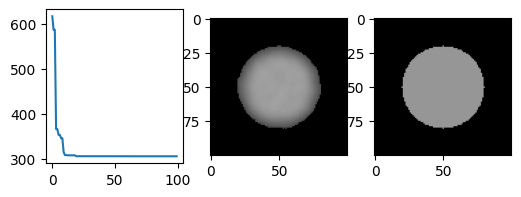

In [10]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="SA", 
        iterations=100,
        verbose=True
)

print(best_params)
pipeline.set_fixed_params(best_params)
i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

### Particle Swarm Optimization (PSO)

{'blur.sigma': 4.216002951082498, 'blur.k': 3, 'threshold.threshold_value': 74}


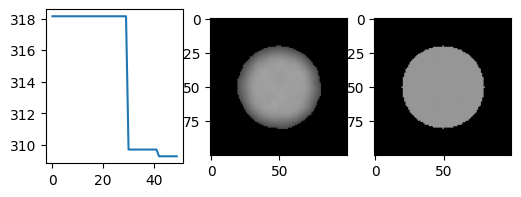

In [11]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="PSO", 
        iterations=50,
        swarm_size=10,
        verbose=True
)

print(best_params)
pipeline.set_fixed_params(best_params)
i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

### Genetic Algorithm (GA)

{'blur.sigma': 8.835524266486397, 'blur.k': 3, 'threshold.threshold_value': 76}


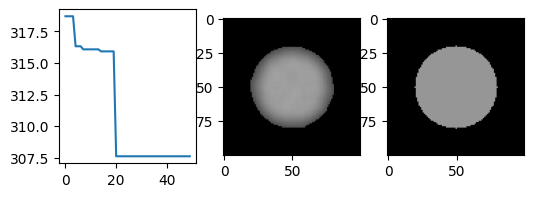

In [12]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="GA", 
        generations=50,
        population_size=50,
        verbose=True
)

print(best_params)
pipeline.set_fixed_params(best_params)
i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

### Grid Search (GS)

{'blur.sigma': 1.2861810140158583, 'blur.k': 5, 'threshold.threshold_value': 76}


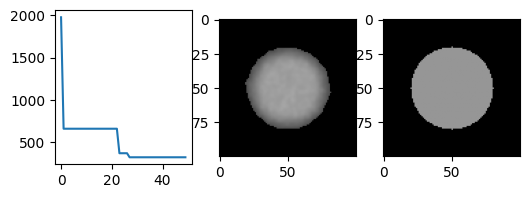

In [13]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="GS", 
        max_combinations=50,
        verbose=True
)

print(best_params)
pipeline.set_fixed_params(best_params)
i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)

### Bayesian Optimization (BO)

{'blur.sigma': 7.3476779082232255, 'blur.k': 2, 'threshold.threshold_value': 76}


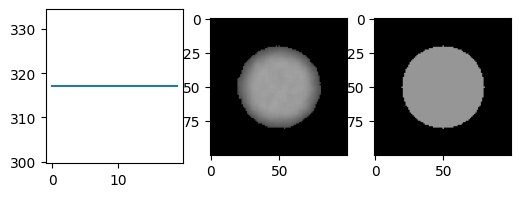

In [14]:
best_params, loss_log = optimizer.optimize(
        X, y,
        method="BO", 
        iterations=20,
        init_points=10,
        verbose=True
)

print(best_params)
pipeline.set_fixed_params(best_params)
i, h, t = pipeline.run(X[0])

plt.figure(figsize=(6,2))
plt.subplot(131)
plt.plot(loss_log)
plt.subplot(132)
plt.imshow(h[i], cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(y[0], cmap="gray", vmin=0, vmax=255)